In [2]:
# google collab
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd gdrive/MyDrive/hackathon/hackathon-airbus/

In [1]:
batch_size = 8

In [2]:
from sklearn import metrics
from ManeuverDetectionDataset import ManeuverDetectionDataset, IrregularDataset, IrregularDatasetInterpolated
from torch.utils.data import DataLoader
import torch
import numpy as np
from cnn import Cnn1d
from trainer import TorchTrainer
from heads import ManeuverTimeHead, DeltaVelocityHead, Wrapper
from inference import InferenceWrapper

## Loading all sort of data

In [10]:
def load_npz(path, with_time=True):
    with np.load(path) as data:
        if(with_time):
            data = {
                'x_scaled': data['x_scaled'],
                'y_scaled': data['feature_ra'],
                'y_scalers': data['y_scalers'],
                'x_scalers': data['x_scaler'],
                'is_maneuver': data['is_maneuver']
            }
        else:
            data = {
                # 'x_scaled': data['x_scaled'],
                'y_scaled': data['feature_ra'],
                'y_scalers': data['y_scalers'],
                # 'x_scalers': data['x_scaler'],
                # 'is_maneuver': data['is_maneuver']
            }
        return data

def build_inputs(ra_data, dec_data):
    time_scaled_dec = dec_data['x_scaled']
    # time_scaled_ra = ra_data['x_scaled']
    ra = ra_data['y_scaled']
    dec = dec_data['y_scaled']

    assert(len(ra) == len(dec))
    # assert(len(time_scaled_dec) == len(ra.shape[1]))
    return (np.stack([
            ra,
            dec
            ], axis=1), # time_scaled_dec.unsqqu : time is not included as it is the same of everyone
            (ra_data['y_scalers'],
             dec_data['y_scalers'],
             dec_data['x_scalers']))

def get_other_outputs_tmp(is_maneuver, kind="TRAIN"):
    dataset_path="DATA/TRAIN_1_IRREGULAR_STEPS_V2.json"
    train_dataset = IrregularDataset([
        ManeuverDetectionDataset(dataset_path, dataset_type=kind)])
    outputs = []
    for i in range(len(train_dataset)):
        x, y = train_dataset[i]
        assert(is_maneuver[i] == y[0])
        outputs.append(y)
    return outputs

def get_man_only(x, y):
    x_man = []
    y_man = []
    for x_, y_ in zip(x, y):
        if(y_[0] == 1):
            x_man.append(x_)
            y_man.append(y_)
    return np.array(x_man), y_man

def build_outputs(ra_data, dec_data, kind):
    # is_maneuver_ra = ra_data['is_maneuver']
    is_maneuver_dec = dec_data['is_maneuver']
    # assert(np.array_equal(is_maneuver_ra, is_maneuver_dec))
    other_outputs = get_other_outputs_tmp(is_maneuver_dec, kind)
    outputs = []
    assert(len(other_outputs) == is_maneuver_dec.shape[0])
    for i, c in enumerate(is_maneuver_dec):
        other = other_outputs[i]
        outputs.append((c, other[1], other[2])) # for now : 0., 0.
    return (outputs, None)
    # for now, no knowledge of dv and time, and thus no scalers

def build_empty_outputs(size):
    outputs = []
    for k in range(size):
        outputs.append((0, 0, 0))
    return outputs, None

def load_interpolated_dataset(root_path, kind='TRAIN', filter_samples='NO'): # train, test, valid
    # filter_samples : "NO", "MANEUVER_ONLY"
    if(kind == 'TRAIN'):
        if(filter_samples == 'MANEUVER_ONLY'):
            dec_path = root_path +  'interpolated_dec_train_maneuvre_only.npz'
            ra_path = root_path + 'interpolated_ra_train_maneuvre_only.npz'
            # dec_path = [root_path +  'interpolated_dec_train_maneuvre_only.npz', root_path +  'interpolated_dec_train_maneuvre_only_2.npz']
            # ra_path = [root_path +  'interpolated_ra_train_maneuvre_only.npz', root_path +  'interpolated_ra_train_maneuvre_only_2.npz']
            # root_path + 'interpolated_ra_train_maneuvre_only.npz'
        else:
            dec_path = root_path +  'interpolated_dec_train.npz'
            ra_path = root_path + 'interpolated_ra_train.npz'
    elif(kind == 'TEST'):
        dec_path = root_path +  'interpolated_dec_test.npz'
        ra_path = root_path + 'interpolated_ra_test.npz'
    elif(kind == 'VALIDATION'):
        if(filter_samples == 'MANEUVER_ONLY'):
            dec_path = root_path +  'interpolated_dec_validation_maneuvre_only.npz'
            ra_path = root_path + 'interpolated_ra_validation_maneuvre_only.npz'
        else:
            dec_path = root_path +  'interpolated_dec_validation.npz'
            ra_path = root_path + 'interpolated_ra_validation.npz'
    else:
        print('ERROR in dataset kind')
    
    dec_data = load_npz(dec_path, with_time=True)
    ra_data = load_npz(ra_path, with_time=False)
    x, x_scalers = build_inputs(ra_data, dec_data)
    if(kind in ['TRAIN', 'VALIDATION']):
        y, y_scalers = build_outputs(ra_data, dec_data, kind) # no scale
        full_dataset = IrregularDatasetInterpolated(torch.tensor(x).float(), y, x_scalers, y_scalers)
        x_man, y_man = get_man_only(x, y)
        full_dataset_man = IrregularDatasetInterpolated(torch.tensor(x_man).float(), y_man, x_scalers, y_scalers)
        return full_dataset, full_dataset_man
    else:
        y, y_scalers = build_empty_outputs(x.shape[0])
        full_dataset = IrregularDatasetInterpolated(torch.tensor(x).float(), y, x_scalers, y_scalers)
        return full_dataset

In [11]:
use_interpolated = False
if(use_interpolated):
    root_path = "DATA/interpolated/"
    train_dataset, train_dataset_man_only = load_interpolated_dataset(root_path, kind='TRAIN', filter_samples='NO')
    # valid_dataset, valid_dataset_man_only = load_interpolated_dataset(root_path, kind='VALIDATION', filter_samples='NO')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
    valid_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=False) # same for now...
    train_loader_man_only = DataLoader(train_dataset_man_only, batch_size=batch_size, drop_last=False, shuffle=True)
    valid_loader_man_only = DataLoader(train_dataset_man_only, batch_size=batch_size, drop_last=False, shuffle=False)

    test_dataset = load_interpolated_dataset(root_path, kind='TEST', filter_samples='NO')
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
else:
    dataset_path="DATA/TRAIN_1_IRREGULAR_STEPS_V2.json"
    dataset_path_2="DATA/TRAIN_2_IRREGULAR_STEPS.json"
    ## All datadv_list
    train_dataset = IrregularDataset([
        ManeuverDetectionDataset(dataset_path, dataset_type="TRAIN"),
        ManeuverDetectionDataset(dataset_path_2, dataset_type="TRAIN")])
    valid_dataset = IrregularDataset([
        ManeuverDetectionDataset(dataset_path, dataset_type="VALIDATION"),
        ManeuverDetectionDataset(dataset_path_2, dataset_type="VALIDATION")])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

    ## Maneuver only
    train_dataset_man_only = IrregularDataset([
        ManeuverDetectionDataset(dataset_path, dataset_type="TRAIN", filter_samples='MANEUVER_ONLY'),
        ManeuverDetectionDataset(dataset_path_2, dataset_type="TRAIN", filter_samples='MANEUVER_ONLY')])
    valid_dataset_man_only = IrregularDataset([
        ManeuverDetectionDataset(dataset_path, dataset_type="VALIDATION", filter_samples='MANEUVER_ONLY'),
        ManeuverDetectionDataset(dataset_path_2, dataset_type="VALIDATION", filter_samples='MANEUVER_ONLY')])

    train_loader_man_only = DataLoader(train_dataset_man_only, batch_size=batch_size, drop_last=False, shuffle=True)
    valid_loader_man_only = DataLoader(valid_dataset_man_only, batch_size=batch_size, drop_last=False, shuffle=False)

    test_dataset_path="DATA/TEST_FILE_PUBLIC.json"
    test_dataset= ManeuverDetectionDataset(test_dataset_path, dataset_type="TEST")
    test_dataset_irr = IrregularDataset([ManeuverDetectionDataset(dataset_path, dataset_type="TEST", imported_dataset=test_dataset.dataset)])
    test_loader = DataLoader(test_dataset_irr, batch_size=1, drop_last=False)



**********TRAIN DATASET *********
Validation/Train ratio: 0.1
Samples filtered? NO
Samples evenly spaced? False
path: DATA/TRAIN_1_IRREGULAR_STEPS_V2.json
loading dataset. Ready in a minute!
TRAIN Dataset loaded. Size: 35762


**********TRAIN DATASET *********
Validation/Train ratio: 0.1
Samples filtered? NO
Samples evenly spaced? False
path: DATA/TRAIN_2_IRREGULAR_STEPS.json
loading dataset. Ready in a minute!
TRAIN Dataset loaded. Size: 33526


**********VALIDATION DATASET *********
Validation/Train ratio: 0.1
Samples filtered? NO
Samples evenly spaced? False
path: DATA/TRAIN_1_IRREGULAR_STEPS_V2.json
loading dataset. Ready in a minute!
VALIDATION Dataset loaded. Size: 3974


**********VALIDATION DATASET *********
Validation/Train ratio: 0.1
Samples filtered? NO
Samples evenly spaced? False
path: DATA/TRAIN_2_IRREGULAR_STEPS.json
loading dataset. Ready in a minute!
VALIDATION Dataset loaded. Size: 3725


**********TRAIN DATASET *********
Validation/Train ratio: 0.1
Samples filtered

# CNN / TCNN without interpolated data (almost no preprocessing on the data)
Detect which time series contain maneuvers.

CNN to determine on full time series, not evenly spaced, if it contains a maneuver or not.

Fixed size of the time series : 1000 (48h of data).

### Irregular

In [6]:
block_kwargs_list_1000 = [
    { # layer 1
        'conv_kwargs': {
            'in_channels': 3,
            'out_channels': 4,
            'kernel_size': 11,
            'stride': 1,
            'padding': 0,
            'dilation': 1,
            'groups': 1,
            'bias': True,
            'padding_mode': 'zeros'
        },
        'pool_kwargs': {
            'kernel_size': 11,
            'stride': None,
            'padding': 0,
            'dilation': 1
        },
        'dropout_rate': 0.0
    },
    { # layer 2
        'conv_kwargs': {
            'in_channels': 4,
            'out_channels': 3,
            'kernel_size': 11,
            'stride': 1,
            'padding': 0,
            'dilation': 1,
            'groups': 1,
            'bias': True,
            'padding_mode': 'zeros'
        },
        'pool_kwargs': {
            'kernel_size': 11,
            'stride': None,
            'padding': 0,
            'dilation': 1
        },
        'dropout_rate': 0.0
    },
    # { # layer 3
    #     'conv_kwargs': {
    #         'in_channels': 6,
    #         'out_channels':6,
    #         'kernel_size': 5,
    #         'stride': 1,
    #         'padding': 0,
    #         'dilation': 1,
    #         'groups': 1,
    #         'bias': True,
    #         'padding_mode': 'zeros'
    #     },
    #     'pool_kwargs': {
    #         'kernel_size': 5,
    #         'stride': None,
    #         'padding': 0,
    #         'dilation': 1
    #     },
    #     'dropout_rate': 0.0
    # }
]
linear_kwargs_1000 = {
    'in_features': 21,
    'out_features': 10 # size of the projection space (dimension reduction)
}

conv_net_1000 = Cnn1d(block_kwargs_list_1000, linear_kwargs_1000, output_size=2).float()

# test
c = conv_net_1000(torch.zeros(4, 3, 1000).float())

### Interpolated

In [41]:
block_kwargs_list_433 = [
    { # layer 1
        'conv_kwargs': {
            'in_channels': 2,
            'out_channels': 4,
            'kernel_size': 7,
            'stride': 1,
            'padding': 0,
            'dilation': 1,
            'groups': 1,
            'bias': True,
            'padding_mode': 'zeros'
        },
        'pool_kwargs': {
            'kernel_size': 7,
            'stride': None,
            'padding': 0,
            'dilation': 1
        },
        'dropout_rate': 0.0
    },
    { # layer 2
        'conv_kwargs': {
            'in_channels': 4,
            'out_channels': 6,
            'kernel_size': 7,
            'stride': 1,
            'padding': 0,
            'dilation': 1,
            'groups': 1,
            'bias': True,
            'padding_mode': 'zeros'
        },
        'pool_kwargs': {
            'kernel_size': 7,
            'stride': None,
            'padding': 0,
            'dilation': 1
        },
        'dropout_rate': 0.0}
]
linear_kwargs_433 = {
    'in_features': 42,
    'out_features': 10 # size of the projection space (dimension reduction)
}

conv_net_433 = Cnn1d(block_kwargs_list_433, linear_kwargs_433).float()

# test
c = conv_net_433(torch.zeros(4, 2, 433).float())

## Training maneuver classifier 

### Models
#### TCNN

In [25]:
from tcnn import TCNModel
channel = 20
num_inputs = 433 # 1000
tcn_model = TCNModel(num_inputs=num_inputs, num_channels=[channel, channel]).float()

In [72]:
# torch.save(tcn_model.state_dict(), 'tcnn_433_20.pt')
# torch.save(conv_net_433.state_dict(), 'cnn_433_42.pt')
conv_net_433.load_state_dict(torch.load('cnn_433_42.pt'))
tcn_model.load_state_dict(torch.load('tcnn_433_20.pt'))

<All keys matched successfully>

In [73]:
trainer_tcnn = TorchTrainer(model=tcn_model)

In [ ]:
for lr in [1e-3, 5e-4, 2e-4, 1e-4]: # 1e-3, 5e-4, 2e-4, 1e-4]: # 5e-3, 2e-3, 
    print(trainer_tcnn.train(train_loader, epochs=3, lr=lr))

In [74]:
true_valid, pred_valid = trainer_tcnn.predict(valid_loader, return_true=True)
true_train, pred_train = trainer_tcnn.predict(train_loader, return_true=True)

In [75]:
print(torch.count_nonzero((pred_valid[0] > 0.5) == true_valid[0])/true_valid[0].shape[0])
print(torch.count_nonzero((pred_train[0] > 0.5) == true_train[0])/true_train[0].shape[0])

y_true, y_pred = true_train[0].cpu().numpy(), (pred_train[0]>0.5).cpu().numpy()
print(metrics.confusion_matrix(y_true, y_pred))

y_true, y_pred = true_valid[0].cpu().numpy(), (pred_valid[0]>0.5).cpu().numpy()
print(metrics.confusion_matrix(y_true, y_pred))

tensor(0.8769)
tensor(0.8769)
[[17002   848]
 [ 3555 14355]]
[[17001   848]
 [ 3555 14356]]


#### CNN

In [14]:
trainer = TorchTrainer(model=conv_net_1000, loss_function='CrossEntropyLoss')

In [15]:
for lr in [1e-3, 5e-4, 2e-4, 1e-4, 5e-4]: # 5e-3, 2e-3,  2e-4, 1e-4, 5e-4
    print(trainer.train(train_loader, epochs=5, lr=lr))

4 - loss: 0.42: 100%|██████████| 5/5 [01:49<00:00, 21.85s/it]


[0.55951875, 0.480092, 0.46618447, 0.4343683, 0.41722682]


4 - loss: 0.40: 100%|██████████| 5/5 [01:33<00:00, 18.77s/it]


[0.40615425, 0.40392682, 0.40102035, 0.39796236, 0.39607286]


4 - loss: 0.39: 100%|██████████| 5/5 [01:37<00:00, 19.48s/it]


[0.39020205, 0.38996103, 0.3897625, 0.38956282, 0.3892921]


4 - loss: 0.39: 100%|██████████| 5/5 [01:50<00:00, 22.01s/it]


[0.3869114, 0.38665918, 0.38665652, 0.38665402, 0.38638273]


4 - loss: 0.39: 100%|██████████| 5/5 [01:22<00:00, 16.55s/it]

[0.39342478, 0.39297736, 0.39297727, 0.391781, 0.39052454]


In [16]:
true_valid, pred_valid = trainer.predict(valid_loader, return_true=True)
true_train, pred_train = trainer.predict(train_loader, return_true=True)

In [21]:
torch.argmax(pred_valid[0])

tensor(4745)

In [22]:
# print(torch.count_nonzero((pred_valid[0] > 0.5) == true_valid[0])/true_valid[0].shape[0])
# print(torch.count_nonzero((pred_train[0] > 0.5) == true_train[0])/true_train[0].shape[0])
print(torch.count_nonzero(torch.argmax(pred_valid[0], dim=1) == true_valid[0])/true_valid[0].shape[0])
print(torch.count_nonzero(torch.argmax(pred_train[0], dim=1)  == true_train[0])/true_train[0].shape[0])
y_true, y_pred = true_train[0].cpu().numpy(), (pred_train[0]>0.5).cpu().numpy()
print(metrics.confusion_matrix(y_true, y_pred))

y_true, y_pred = true_valid[0].cpu().numpy(), (pred_valid[0]>0.5).cpu().numpy()
print(metrics.confusion_matrix(y_true, y_pred))

tensor(0.8351)
tensor(0.8307)


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

# Second Step - Training regressor heads for maneuver time and dV determinations

CNN / TCNN (base net for the classifier, i.e. classifier without the classification head) is frozen here. Only the regression head (time & dv) is trained.

In [28]:
base_net = tcn_model # conv_net_1000
in_features = channel # linear_kwargs_1000['in_features'] # channel

maneuver_time_net = ManeuverTimeHead(channel) # linear_kwargs_433['in_features'])
dv_net = DeltaVelocityHead(channel)

# freeze network
for param in base_net.parameters():
    param.requires_grad = False

time_net_wrapper = Wrapper(tcn_model, maneuver_time_net)
dv_net_wrapper = Wrapper(tcn_model, dv_net)

#### Time trainer

In [ ]:
time_trainer = TorchTrainer(model=time_net_wrapper, index_y=2, loss_function='L1Loss')

In [ ]:
for lr in [2e-3, 1e-3, 5e-4]: # 2e-3, 1e-3, 
    print(time_trainer.train(train_loader_man_only, epochs=5, lr=lr))


#### dV Trainer

In [ ]:
dv_trainer = TorchTrainer(model=dv_net_wrapper, index_y=1, loss_function='L1Loss')

In [ ]:
for lr in [2e-3, 1e-3, 5e-4]:
    print(dv_trainer.train(train_loader_man_only, epochs=5, lr=lr))

In [ ]:
true_time, pred_time = time_trainer.predict(valid_loader_man_only, return_true=True)
true_dv, pred_dv = dv_trainer.predict(valid_loader_man_only, return_true=True)

l1_loss = torch.nn.L1Loss()
print(l1_loss(true_time[0], pred_time[0]))
print(l1_loss(true_dv[0], pred_dv[0]))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
sns.scatterplot(true_time[0].cpu().numpy(), pred_time[0].cpu().numpy())

## Third step : training the base net

Now that we have full network working with the frozen net, we will duplicate this base net and create new network, one per regression (time & dv) and trained it again, this time all the layers.

In [45]:
base_net ='tcnn'  # cnn
# if(base_net == 'tcnn'):
base_net_time = tcn_model = TCNModel(num_inputs=num_inputs, num_channels=[channel, channel]).float()
# base_net_dv = tcn_model = TCNModel(num_inputs=num_inputs, num_channels=[channel, channel]).float()
base_net_time.load_state_dict(tcn_model.state_dict())
# base_net_dv.load_state_dict(tcn_model.state_dict())
# else:
  # base_net_time = Cnn1d(block_kwargs_list_433, linear_kwargs_433).float()
base_net_dv = Cnn1d(block_kwargs_list_433, linear_kwargs_433).float()
  # base_net_time.load_state_dict(conv_net_433.state_dict())
base_net_dv.load_state_dict(conv_net_433.state_dict())

time_net_wrapper_bis = Wrapper(base_net_time, maneuver_time_net)
dv_net_wrapper_bis = Wrapper(base_net_dv, dv_net)

for param in time_net_wrapper_bis.parameters():
    param.requires_grad = True

for param in dv_net_wrapper_bis.parameters():
    param.requires_grad = True

### Time

In [25]:
time_trainer_bis = TorchTrainer(model=time_net_wrapper_bis, index_y=2, loss_function='L1Loss')

In [ ]:
for lr in [1e-3, 5e-4, 2e-4, 1e-4, 5e-5]:
    print(time_trainer_bis.train(train_loader_man_only, epochs=3, lr=lr))

In [76]:
# torch.save(time_net_wrapper_bis.state_dict(), 'time_net_tcn_20_433.pt')
time_net_wrapper_bis.load_state_dict(torch.load('time_net_tcn_20_433.pt'))

<All keys matched successfully>

### dV

In [21]:
dv_trainer_bis = TorchTrainer(model=dv_net_wrapper_bis, index_y=1, loss_function='L1Loss')

In [ ]:
for lr in [1e-3, 5e-4, 2e-4, 1e-4, 5e-5]:
    print(dv_trainer_bis.train(train_loader_man_only, epochs=3, lr=lr))

### Results on validation

In [77]:
true_time, pred_time = time_trainer_bis.predict(valid_loader_man_only, return_true=True)
true_dv, pred_dv = dv_trainer_bis.predict(valid_loader_man_only, return_true=True)

In [78]:
l1_loss = torch.nn.L1Loss()
print(l1_loss(true_time[0], pred_time[0]))
print(l1_loss(true_dv[0], pred_dv[0]))

tensor(0.0659, dtype=torch.float64)
tensor(0.7415, dtype=torch.float64)


/home/paul/miniconda3/envs/sdd/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

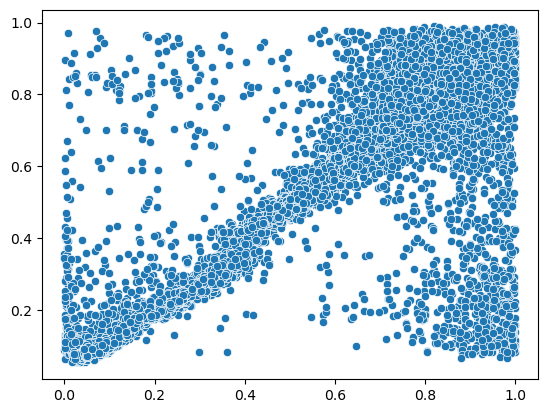

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
sns.scatterplot(true_time[0].cpu().numpy(), pred_time[0].cpu().numpy())

## Inference time !

### XGBOOST

In [ ]:
# xgboost
import pickle
file_name = "xgb_reg.pkl"
# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

with np.load('interpolated_ra_test.npz') as data:
    x_scaled = data['x_scaled']
    test_is_maneuver = data['is_maneuver']
    test_feature_ra = data['feature_ra']
    test_x_scaler = data['x_scaler']
    test_y_scalers = data['y_scalers']

In [ ]:
pred_classification = xgb_model_loaded.predict(test_feature_ra)

### INFERENCE WRAPPER

In [34]:
class InferenceWrapper(torch.nn.Module):
    def __init__(self, classification, dv_net, time_net) -> None:
        super().__init__()
        self.classification = classification
        self.dv_net = dv_net
        self.time_net = time_net
    
    def forward(self, x):
        c, embedding = self.convnet.predict(x)
        dv = self.dv_net(embedding) 
        time = self.time_net(embedding)
        return (c, dv, time), embedding
    
    def predict(self, dataloader, use_convnet_embedding=False):
        self.eval()
        cc_list = []
        time_list = []
        dv_list = []

        time_true = []
        dv_list_true = []
        cc_list_true = []
        # act_fn = torch.nn.Sigmoid()
        with torch.no_grad():
            for x, y in dataloader:
                c, embedding = self.classification(x)
                # if(use_convnet_embedding):
                #     dv, embedding= self.dv_net(embedding)
                #     time, embedding = self.time_net(embedding)
                # else:
                #     dv, embedding = self.dv_net(x)
                #     time, embedding = self.time_net(x)
                # saving preds
                cc_list.append(torch.squeeze(c).cpu().numpy())
                time_list.append(0.5) #torch.squeeze(time).cpu().numpy())
                dv_list.append(0.01) # torch.squeeze(dv).cpu().numpy())

                # saving preds
                time_true.append(y[2].cpu().numpy())
                dv_list_true.append(y[1].cpu().numpy())
                cc_list_true.append(y[0].cpu().numpy())
        return ((np.array(cc_list),
                np.array(dv_list),    
                np.array(time_list)), 
                (cc_list_true,
                 dv_list_true,
                 time_true))

In [38]:
# freeze network
inference_wrapper = InferenceWrapper(
        conv_net_1000, # which one ???
        dv_net=dv_net_wrapper, # _bis,
        time_net=time_net_wrapper, # _bis
)
for param in inference_wrapper.parameters():
    param.requires_grad = False

In [39]:
len(test_loader)

1559

In [49]:
preds, true = inference_wrapper.predict(test_loader)
# pred = np.stack(preds, axis=1) 
# print(pred.shape)

In [50]:
pred = np.argmax(preds[0], axis=1)

In [51]:
pred_ = np.zeros((pred.shape[0], 3))

In [52]:
pred_[:, 0] = pred

In [54]:
pred_[:, 2]=24*3600*pred_[:, 2]
# pred[:, 0] = (pred[:, 0] > 0.5).astype(int)

In [56]:
np.count_nonzero(pred_[:, 0])

577

In [35]:
# using XGBOOST
# preds, true = inference_wrapper.predict(test_loader)
# pred[:, 1] = pred_classification

In [58]:
from SubmissionGenerator import create_submission
import numpy as np
# pred[:,1]=0.01*np.ones((len(test_dataset))) #dv
create_submission(np.double(pred_),"RESULTS/vv")

# Sliding Time Window (TODO, DEPRECIATED)
We split them in several subseries (sliding windows) and we have to find where the anomaly start occuring. 
For each small window, we determine a new score of anomaly. We can refine as many time as required.

May be now we can try predicting the time of the anomaly occuring. I am not sure.

In [ ]:
from ManeuverDetectionDataset import ManeuverDetectionDataset, ManeuverDetectionSlidingWindowDataset
from torch.utils.data import DataLoader

evenly_spaced_dataset_path="DATA/TRAIN_1_EVENLY_SPACED_V2.json"
evenly_spaced_dataset= ManeuverDetectionDataset(evenly_spaced_dataset_path, fixed_step=True) # window_size=30)
evenly_spaced_dataset_sliding_window = ManeuverDetectionSlidingWindowDataset(evenly_spaced_dataset, window_size=433)
# feature,is_maneuver,maneuver_dv,maneuver_time =next(iter(evenly_spaced_loader))
# print(f"features shape (batch size * nb of meas * nb of feature):{feature.shape}\nis maneuver: {is_maneuver.item()}\ndv (m/s): {maneuver_dv.item()}\nmaneuver date (seconds from the observation start): {maneuver_time.item()}")

In [ ]:
evenly_spaced_loader = DataLoader(evenly_spaced_dataset_sliding_window, batch_size=32, drop_last=True, shuffle=True)

In [ ]:
trainer.train(evenly_spaced_loader, epochs=3)

In [ ]:
evenly_spaced_dataset_valid = ManeuverDetectionDataset(evenly_spaced_dataset_path, dataset_type='VALIDATION', fixed_step=True)
valid_set = ManeuverDetectionSlidingWindowDataset(evenly_spaced_dataset_valid, window_size=30)

In [ ]:
valid_loader = DataLoader(evenly_spaced_dataset_sliding_window, batch_size=1, drop_last=False, shuffle=False)

In [ ]:
true, pred = trainer.predict(valid_loader, return_true=True)

In [ ]:
torch.count_nonzero((pred[0] > 0.5) == true[0])/true[0].shape[0]

In [ ]:
from sklearn import metrics
y_true, y_pred = true[0].cpu().numpy(), torch.argmax(pred[0], dim=1).cpu().numpy()
metrics.confusion_matrix(y_true, y_pred) # problem with those definitely - class are completly UNBALANCED. 

In [ ]:
block_kwargs_list_30 = [
    { # layer 1
        'conv_kwargs': {
            'in_channels': 2,
            'out_channels': 4,
            'kernel_size': 3,
            'stride': 1,
            'padding': 0,
            'dilation': 1,
            'groups': 1,
            'bias': True,
            'padding_mode': 'zeros'
        },
        'pool_kwargs': {
            'kernel_size': 3,
            'stride': None,
            'padding': 0,
            'dilation': 1
        },
        'dropout_rate': 0
    },
    { # layer 2
        'conv_kwargs': {
            'in_channels': 4,
            'out_channels': 4,
            'kernel_size': 3,
            'stride': 1,
            'padding': 0,
            'dilation': 1,
            'groups': 1,
            'bias': True,
            'padding_mode': 'zeros'
        },
        'pool_kwargs': {
            'kernel_size': 3,
            'stride': None,
            'padding': 0,
            'dilation': 1
        },
        'dropout_rate': 0
    }
]
linear_kwargs_30 = {
    'in_features': 8,
    'out_features': 10 # size of the projection space (dimension reduction)
}
conv_net_30 = Cnn1d(block_kwargs_list_30, linear_kwargs_30).float()


In [ ]:
19916/536388 * 100 # 3.72% 

In [ ]:
cross_entropy_loss = torch.nn.CrossEntropyLoss() # weight=torch.tensor([0.05, 0.95]))
mae_loss_1 = torch.nn.L1Loss()
mae_loss_2 = torch.nn.L1Loss()
def total_loss_function(pred, true, alpha=0.5, beta=0.1, gamma=0.4):
    c_true, dv_true, date_true = true
    c, dv, date = pred
    return alpha * cross_entropy_loss(c, c_true) + beta * mae_loss_1(dv, dv_true) + gamma * mae_loss_2(date_true, date)
  